<a href="https://colab.research.google.com/github/RuiyunHuang/Chicago_Crime_Analysis/blob/master/Chicago_Crime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Part 0: Environment Setup**

##**0.1 Install package**


In [3]:
!pip install git+https://github.com/python-visualization/folium

  Cloning https://github.com/python-visualization/folium to /tmp/pip-req-build-2jf5tu80
  Running command git clone -q https://github.com/python-visualization/folium /tmp/pip-req-build-2jf5tu80
  Created wheel for folium: filename=folium-0.10.1+6.g4a7532d-py2.py3-none-any.whl size=93921 sha256=604095ecee6ce78f59f7717f14d3ad4c5477f1389395fb201590305ee63ebc86
  Stored in directory: /tmp/pip-ephem-wheel-cache-69oubbrs/wheels/1e/e1/75/ecbc91fd5dd5d90befb0b533bf7492d38acffa033310731862
Successfully built folium


##**0.2 Import packages**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats
import statsmodels.api as sm
import folium as fl

from datetime import datetime

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess

from sklearn.cluster import KMeans

sns.set_palette("husl")
%matplotlib inline

##**0.3 Import data to Colab**

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1hkLBV2uhGO6k_BvV6FsQw2nIFZvLfIW2'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) # replace the id with id of file you want to access
file.GetContentFile('crime.csv')
link_geo='https://drive.google.com/open?id=19qeO1RREzIDsd2KRkb-eKvLETmKVTX0e'
fluff, id = link_geo.split('=')
file = drive.CreateFile({'id':id}) # replace the id with id of file you want to access
file.GetContentFile('geo.geojson')

# **Part 1: Data Cleaning**

In [0]:
raw_data=pd.read_csv('crime.csv')

In [50]:
raw_data.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10786009,HZ554425,12/16/2016 10:30:00 AM,014XX W 78TH ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,True,False,612,6.0,17.0,71.0,05,1168161.0,1853026.0,2016,01/07/2020 03:50:13 PM,41.752236,-87.659334,"(41.752235645, -87.659334168)"
1,10734627,HZ494078,10/28/2016 02:00:00 PM,002XX E 92ND ST,0610,BURGLARY,FORCIBLE ENTRY,POOL ROOM,False,False,633,6.0,9.0,49.0,05,1179757.0,1844042.0,2016,01/07/2020 03:50:13 PM,41.727325,-87.617114,"(41.72732535, -87.617114114)"
2,11694006,JC267197,01/01/2016 12:01:00 AM,048XX W WABANSIA AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,True,2533,25.0,37.0,25.0,17,NaN,NaN,2016,01/06/2020 03:49:40 PM,NaN,NaN,NaN
3,10613199,HZ366157,07/27/2016 12:49:00 AM,116XX S AVENUE M,0620,BURGLARY,UNLAWFUL ENTRY,RESIDENCE-GARAGE,True,False,433,4.0,10.0,55.0,05,1201591.0,1828417.0,2016,01/06/2020 03:49:40 PM,41.683923,-87.537663,"(41.683922677, -87.53766346)"
4,11940434,JD102754,09/01/2016 08:00:00 AM,059XX S INDIANA AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,232,2.0,20.0,40.0,11,NaN,NaN,2016,01/04/2020 03:46:59 PM,NaN,NaN,NaN


In [0]:
raw_data=raw_data.drop(['ID', 'Case Number', 'Location', 'Updated On'], axis=1);

In [52]:
raw_data.shape

(1063214, 18)

In [53]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063214 entries, 0 to 1063213
Data columns (total 18 columns):
Date                    1063214 non-null object
Block                   1063214 non-null object
IUCR                    1063214 non-null object
Primary Type            1063214 non-null object
Description             1063214 non-null object
Location Description    1058984 non-null object
Arrest                  1063214 non-null bool
Domestic                1063214 non-null bool
Beat                    1063214 non-null int64
District                1063213 non-null float64
Ward                    1063194 non-null float64
Community Area          1063208 non-null float64
FBI Code                1063214 non-null object
X Coordinate            1051982 non-null float64
Y Coordinate            1051982 non-null float64
Year                    1063214 non-null int64
Latitude                1051982 non-null float64
Longitude               1051982 non-null float64
dtypes: bool(2), float

In [54]:
raw_data.isnull().sum()

Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     4230
Arrest                      0
Domestic                    0
Beat                        0
District                    1
Ward                       20
Community Area              6
FBI Code                    0
X Coordinate            11232
Y Coordinate            11232
Year                        0
Latitude                11232
Longitude               11232
dtype: int64

#**Part 2: Data Exploration**

###**2.1 Find top 10 crimes**

In [55]:
# take a look at all crime categories
raw_data['Primary Type'].unique()

array(['BURGLARY', 'OFFENSE INVOLVING CHILDREN', 'DECEPTIVE PRACTICE',
       'SEX OFFENSE', 'CRIM SEXUAL ASSAULT', 'BATTERY', 'CRIMINAL DAMAGE',
       'THEFT', 'NARCOTICS', 'HOMICIDE', 'ROBBERY', 'OTHER OFFENSE',
       'WEAPONS VIOLATION', 'MOTOR VEHICLE THEFT', 'ASSAULT',
       'PUBLIC PEACE VIOLATION', 'CRIMINAL TRESPASS', 'NON-CRIMINAL',
       'INTERFERENCE WITH PUBLIC OFFICER', 'ARSON',
       'CONCEALED CARRY LICENSE VIOLATION', 'STALKING', 'KIDNAPPING',
       'LIQUOR LAW VIOLATION', 'PROSTITUTION', 'INTIMIDATION',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'OBSCENITY', 'GAMBLING',
       'NON - CRIMINAL', 'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY',
       'HUMAN TRAFFICKING'], dtype=object)

In [0]:
#remove those non-crimes
non_crime=set(['NON - CRIMINAL', 'NON-CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)'])
raw_data=raw_data[~raw_data['Primary Type'].isin(non_crime)]

          Primary Type  Number of crimes
0                THEFT            253284
1              BATTERY            198942
2      CRIMINAL DAMAGE            114594
3              ASSAULT             79064
4   DECEPTIVE PRACTICE             75170
5        OTHER OFFENSE             68323
6            NARCOTICS             52304
7             BURGLARY             48615
8  MOTOR VEHICLE THEFT             41644
9              ROBBERY             41540


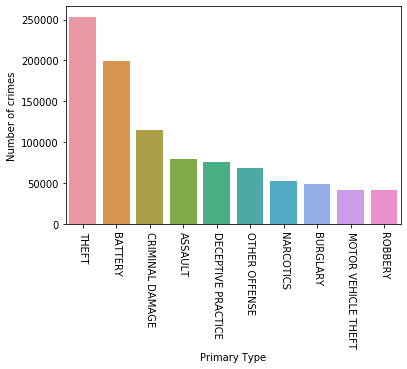

In [57]:
#list top 10 crimes
crime_by_type=raw_data.groupby('Primary Type').size().sort_values(ascending=False).rename('Number of crimes').reset_index().head(10)
print(crime_by_type)
plt.figure()
plt.xticks(rotation=-90)
sns.barplot(x='Primary Type', y='Number of crimes', data=crime_by_type)

###**2.2 List top 10 dangerous districts**

In [58]:
raw_data['District'].unique()

array([ 6., 25.,  4.,  2., 16., 15.,  5.,  7., 20., 14., 19.,  8., 12.,
       22., 10., 17.,  3., 11.,  9., 18., 24.,  1., 31., nan])

  District  Number of crimes
0       11             73960
1        6             65932
2        8             65919
3        1             59903
4       18             59551
5        4             57828
6        7             55844
7       25             54900
8       12             53735
9       10             50073


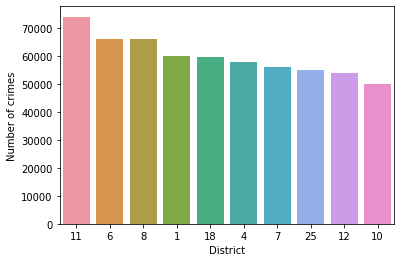

In [59]:
# list top district
crime_by_district=raw_data.groupby('District').size().sort_values(ascending=False).rename('Number of crimes').reset_index().head(10)
crime_by_district['District']=crime_by_district['District'].astype(int).astype(str)
print(crime_by_district)
plt.figure()
sns.barplot(x='District', y='Number of crimes', data=crime_by_district, order=crime_by_district['District'])

###**2.3 Time dependence of crimes**

In [0]:
# parse date 
raw_data['Date']=pd.to_datetime(raw_data['Date'], format='%m/%d/%Y %I:%M:%S %p')
raw_data['Day']=raw_data['Date'].dt.day
raw_data['Month']=raw_data['Date'].dt.month
raw_data['DayofWeek']=raw_data['Date'].dt.dayofweek
raw_data['Hour']=raw_data['Date'].dt.hour

In [0]:
years=[2016, 2017, 2018, 2019]
months_temp=['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']
hour_temp=np.arange(0, 25, 1).tolist()

**By month**

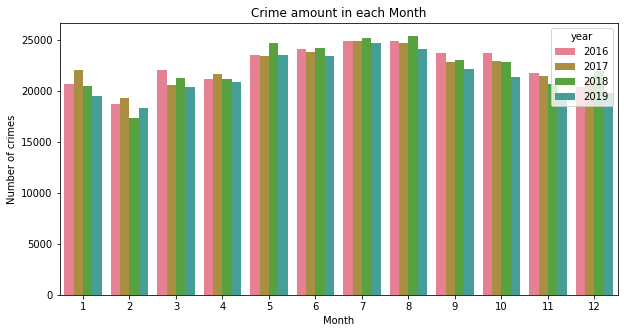

In [62]:
crime_by_Month=pd.DataFrame()
for _ in years:
  tmp=raw_data[raw_data.Year == _].groupby('Month')\
  .size().rename('Number of crimes').reset_index()
  tmp['year']=_
  crime_by_Month=pd.concat([crime_by_Month, tmp])

plt.figure(figsize=[10, 5])
plt.title('Crime amount in each Month')
sns.barplot(x=crime_by_Month.Month, y=crime_by_Month['Number of crimes'], hue=crime_by_Month.year, data=crime_by_Month)

**By day of week**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


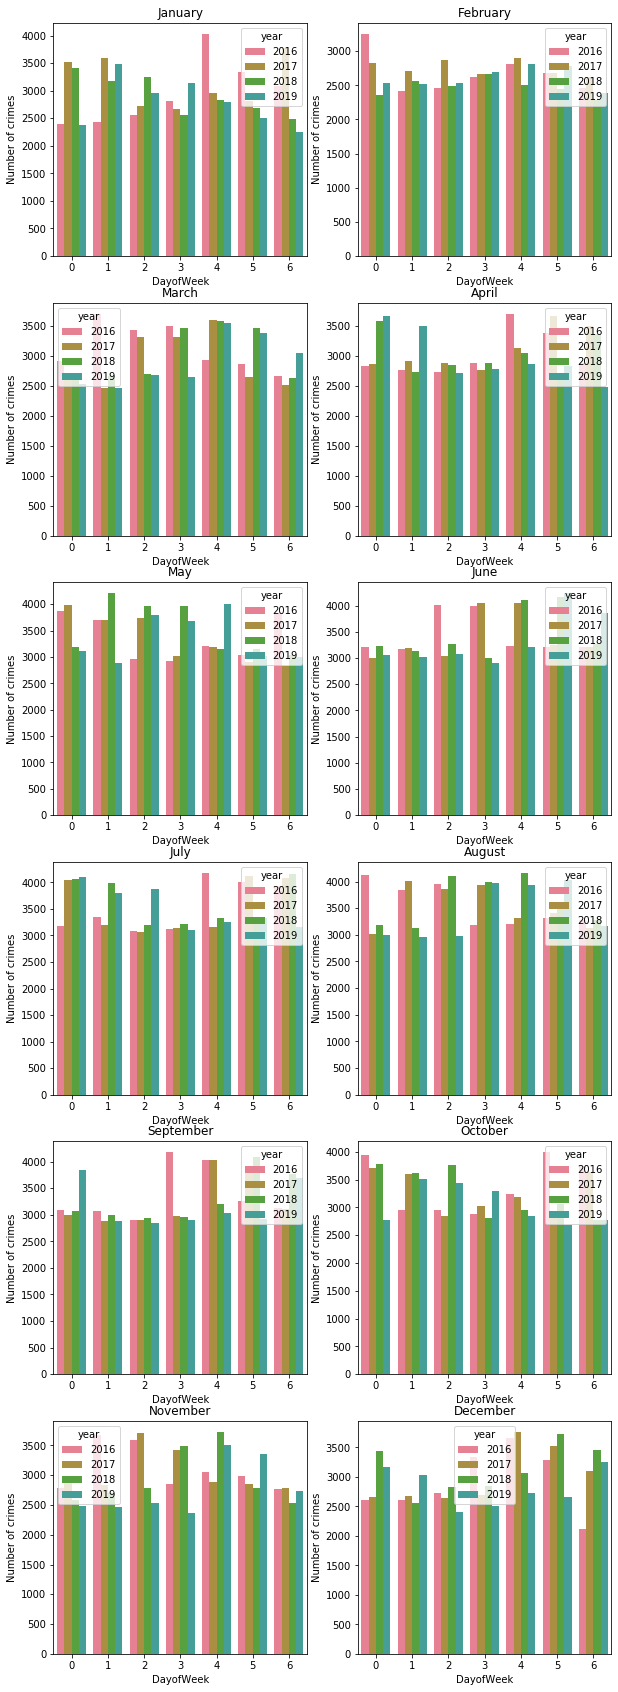

In [63]:
months=np.arange(1, 13, 1)
plt.figure(figsize=[10, 30])
for i in months:
  crime_by_dayofweek=pd.DataFrame()
  tmp=raw_data[(raw_data.Month == i)]
  for j in years:
    tmp_j=tmp[raw_data.Year == j].groupby('DayofWeek')\
    .size().rename('Number of crimes').reset_index()
    tmp_j['year']=j
    crime_by_dayofweek=pd.concat([crime_by_dayofweek, tmp_j])
  plt.subplot(6, 2, i)
  plt.title(months_temp[i-1])
  sns.barplot(x=crime_by_dayofweek.DayofWeek, y=crime_by_dayofweek['Number of crimes'], hue=crime_by_dayofweek.year, data=crime_by_dayofweek)

**By hour**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


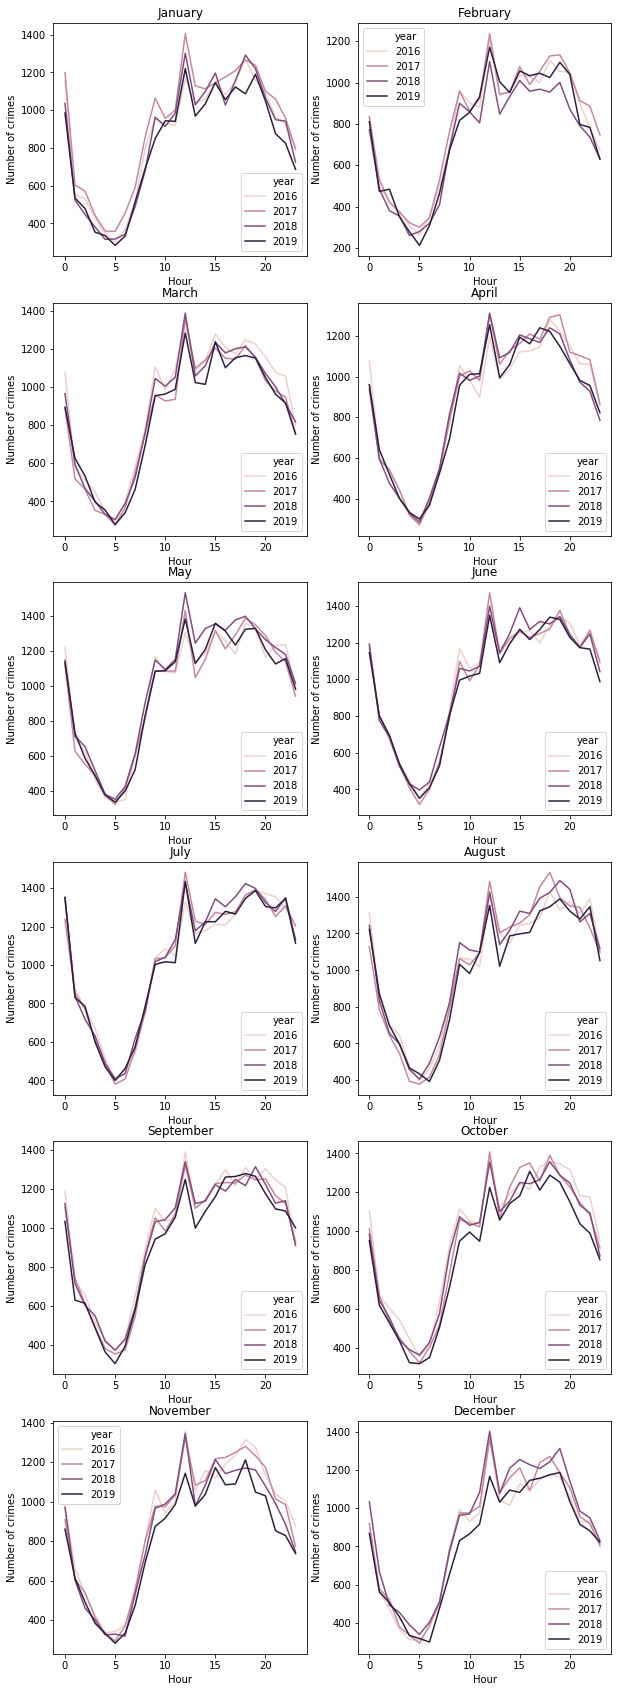

In [64]:
plt.figure(figsize=[10, 30])
for i in months:
  crime_by_hour=pd.DataFrame()
  tmp=raw_data[(raw_data.Month == i)]
  for j in years:
    tmp_j=tmp[raw_data.Year == j].groupby('Hour')\
    .size().rename('Number of crimes').reset_index()
    tmp_j['year']=j
    crime_by_hour=pd.concat([crime_by_hour, tmp_j])
  plt.subplot(6, 2, i)
  plt.title(months_temp[i-1])
  sns.lineplot(x=crime_by_hour.Hour, y=crime_by_hour['Number of crimes'], hue=crime_by_hour.year, data=crime_by_hour)

#**Part 3: Visualization**

In [0]:
chicago_cor=[41.8781, -87.6298]
Time_type='Hour'
Crime_type='ROBBERY'

In [0]:
location_list=raw_data[(~raw_data.Latitude.isnull()) & (raw_data.Year == 2019) & (raw_data['Primary Type'] == Crime_type)][['Latitude', 'Longitude', Time_type]]
location_list['xy']=location_list[['Latitude', 'Longitude']].values.tolist()
location_list=location_list[['xy', Time_type]].groupby(Time_type).agg(list)
lc=location_list['xy'].values.tolist()

In [67]:
from folium.plugins import HeatMapWithTime
chicago_cor=[41.8781, -87.6298]
m = fl.Map(location=chicago_cor, zoom_start=11)
HeatMapWithTime(lc, index=location_list.index.tolist(), radius=10).add_to(m)
m

#**Part 4: Modeling**

In [0]:
tour_months=set([6, 7, 8])
train_X = raw_data[(raw_data.Year==2019) & (raw_data.Month.isin(tour_months)) & (raw_data['Primary Type'] == Crime_type)][['Latitude', 'Longitude']].dropna()

In [0]:
def k_means(train, n):
  model=KMeans(n)
  model.fit(train)
  predictions=model.predict(train)
  train['predictions']=predictions
  return train

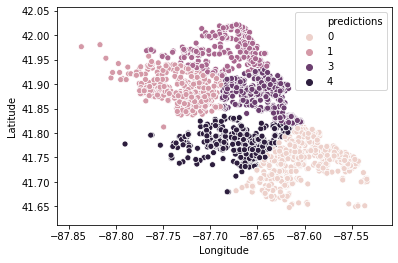

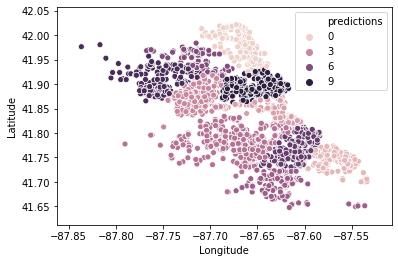

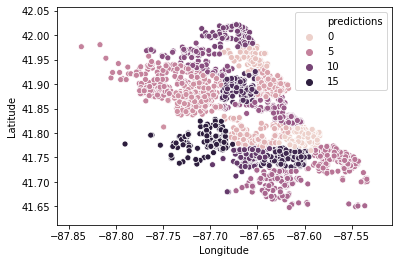

In [99]:
for n in range(5, 20, 5):
  result=k_means(train_X, n)
  plt.figure()
  sns.scatterplot(x=result.Longitude, y=result.Latitude, hue=result.predictions, data=result)
  plt.show()

In [0]:
train_X=train_X.sort_values(by='predictions').reset_index(drop=True).values.tolist()

In [101]:
colors=['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', \
        'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray', 'red', 'blue']
m1 = fl.Map(location=chicago_cor, zoom_start=12)
for _ in train_X:
  fl.vector_layers.CircleMarker(location=[_[0], _[1]], radius=1, color=colors[int(_[2])]).add_to(m1)
m1